In [25]:
#import libraries

import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import pickle

In [26]:
#importing and concating values and labels


X = pd.read_csv('training_set_values.csv', index_col = 0)
y = pd.read_csv('training_set_labels.csv', index_col = 0)

df = pd.concat([X, y], axis = 1)

In [6]:
classes = ['functional', 'functional needs repair', 'non functional'] #labels used for confusion matrix

#### remove: wpt_name, date_recorded, region_code, recorded_by, scheme_name, extraction_type, payment_type, water_quality, quantity_group, source

#### possibly to remove: funder, long/lat, num_private, installer, subvillage

#### Maybe: district_code, lga, ward, scheme_management/management, extraction_type_group, management_group

#### Dummies: Basin, region, public_meeting, permit, extraction_type_class, payment, quality_group, quantity, source_type, source_class, waterpoint_type_group

#### Continuous: amount_tsh, gps_height, population, construction_year (look at 0's)

In [6]:
#dropping unecessary columns for first model

df3 = df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by','scheme_name', 'extraction_type', 
                         'payment_type', 'water_quality', 'quantity_group', 'source', 'waterpoint_type','funder', 
                         'longitude', 'latitude', 'num_private', 'installer', 'subvillage', 'district_code', 'lga', 
                         'ward', 'scheme_management', 'management', 'extraction_type_group', 'management_group', 
                         'construction_year'], inplace = True)

In [ ]:
df3.dropna(inplace = True)

## Making Dummies

In [106]:
#make dummies for cats 

basin_dummies = pd.get_dummies(df3['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(df3['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(df3['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(df3['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(df3['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(df3['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(df3['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(df3['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(df3['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)


permit_dict = {True: 1,
               False: 0}

df3[['permit', 'public_meeting']] = df3[['permit', 'public_meeting']].replace(permit_dict)

In [107]:
#concat cats and conts

df3 = pd.concat([df3, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                quality_dummies, quantity_dummies], axis = 1)

In [108]:
#drop original cats (replaced by dummy cats)

df3.drop(columns = ['basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

In [109]:
X3 = df3.drop(columns = ['status_group'], axis = 1)
y3 = df3['status_group']

## Basic_Model

In [113]:
#split our data for training and testing

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=23)

In [114]:
#scaling data for KNN

scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

## KNN Model (Basic Set #1)

In [115]:
#initialize KNN model with no parameters

knn_df3 = KNeighborsClassifier()

In [116]:
#fitting the data to the KNN model + predicting

knn_df3.fit(X3_train, y3_train)

y_pred_knn3 = knn_df3.predict(X3_test)
y_train_knn3 = knn_df3.predict(X3_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [117]:
# checking test accuracy for KNN model
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_knn3))

# checking train accuracy for KNN model
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_knn3))

ValueError: Found input variables with inconsistent numbers of samples: [14850, 13321]

In [24]:
#confusiong mtrx 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[6091  222  880]
 [ 581  247  145]
 [1423  113 3619]]


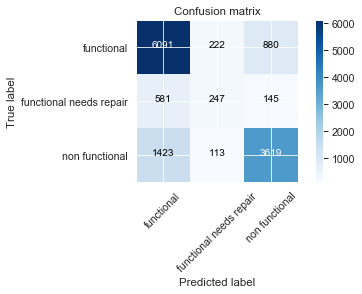

In [25]:
#plot confusion

plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_knn3), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Forest (Best set #2)

In [37]:
#random forest model

rfc_df3 = RandomForestClassifier(class_weight='balanced', criterion = 'entropy', max_depth = 16, 
                                 n_estimators = 200, random_state = 23, n_jobs = -1)

In [38]:
#fitting random forest model + predicting

rfc_df3.fit(X3_train, y3_train)

y_pred_rfc3 = rfc_df3.predict(X3_test)
y_train_rfc3 = rfc_df3.predict(X3_train)

In [39]:
# checking test accuracy for rfm
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_rfc3))

# checking train accuracy for rfm
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_rfc3))

Test Accuracy score:  0.7239696719465506
Train Accuracy score:  0.7985235235235235


### Random Forest Gridsearch 

In [29]:
#grid search for rfm

params_df3 = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 
              'criterion': ['gini', 'entropy']} 

In [30]:
#fitting grid search + predicting

grid_df3 = GridSearchCV(rfc_df3, params_df3, verbose = 1, n_jobs = -1, cv = 5, scoring = 'accuracy')

grid_df3.fit(X3_train, y3_train)


y_pred_gridrf = grid_df3.best_estimator_.predict(X3_test)
y_train_gridrf = grid_df3.best_estimator_.predict(X3_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s


KeyboardInterrupt: 

In [ ]:
# checking test accuracy for grid search rfm
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_gridrf))

# checking train accuracy for grid search rfm
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_gridrf))

## XGB Model 

In [120]:
#XGB Model 

xgb_df3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [122]:
#fitting and predicting XGB

xgb_df3.fit(X3_train, y3_train)

y_pred_xgb3 = xgb_df3.predict(X3_test)

y_train_xgb3 = xgb_df3.predict(X3_train)

In [123]:
# checking test accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb3))

# checking train accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb3))

Test Accuracy score:  0.7812794612794612
Train Accuracy score:  0.8483950617283951


## XGB Gridsearch

In [49]:
#grid search for XGB

param_xgb = {'max_depth' : [4, 6, 8, 10], 'learning_rate' : [.01, .05, .1, .2], 
             'n_estimators' : [100, 250, 500], 'min_child_weight' : [1,3,5]}


In [51]:
#fitting the gridsearch for XGB

grid_xgb = GridSearchCV(xgb_df3, param_xgb, n_jobs = -1, cv = 3, verbose = 1)

grid_xgb.fit(X3_train, y3_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 182.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=23,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [55]:
#predicting test and train with best estimator

y_pred_xgb_grid = grid_xgb.best_estimator_.predict(X3_test)
y_train_xgb_grid = grid_xgb.best_estimator_.predict(X3_train)

In [57]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb_grid))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb_grid))

Test Accuracy score:  0.7781698070715412
Train Accuracy score:  0.8236486486486486


Confusion Matrix, without normalization
[[6444  141  608]
 [ 619  215  139]
 [1394   54 3707]]


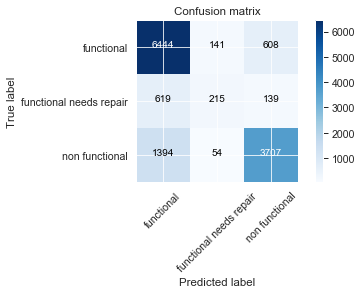

In [58]:
#confusion matrix for xgb model

plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_xgb_grid), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

ID of the wells

In [47]:
#storing id of wells to concat to predictions later

id_df = test_df.reset_index()['id']

## Figuring out how to differentiate the predictions more (EDA) :

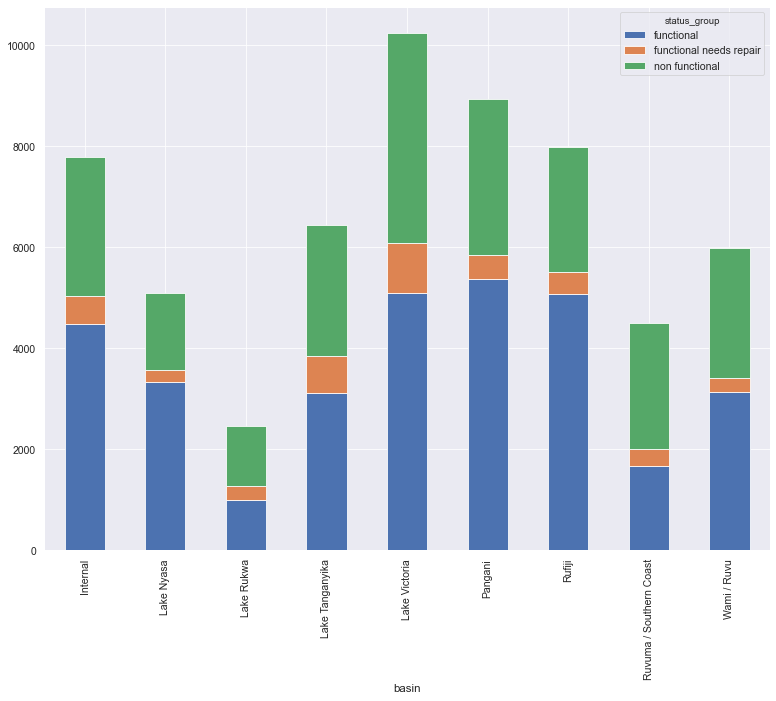

In [34]:
#Basin by status group

df.groupby('basin')['status_group'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(13,10))
plt.show()

In [2]:
#Top funders separated by status_group
#Government Of Tanzania, Danida, Hesawa are the top 3 we kept

df.groupby('funder')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True, figsize=(13,10))

NameError: name 'df' is not defined

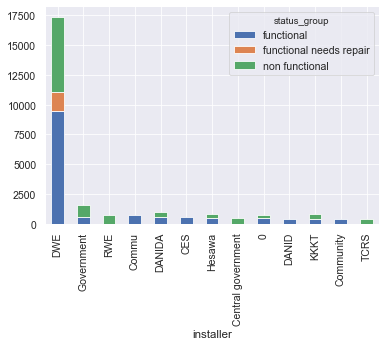

In [74]:
#top installers by status_group, we kept only DWE and Government

df.groupby('installer')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True, figsize=(13,10))

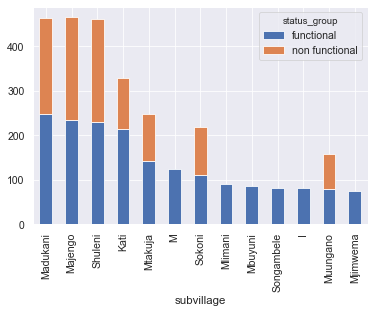

In [75]:
#top subvillage by status group, we kept the top 3: Madukani, Majengo, and Shuleni

df.groupby('subvillage')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True, figsize=(13,10))

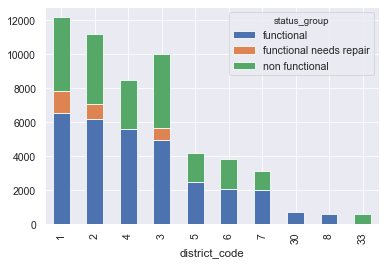

In [77]:
#District Code by status group and only keeping 1,2,3,4

df.groupby('district_code')['status_group'].value_counts().sort_values(ascending = False).head(20).unstack().plot(kind = 'bar', stacked = True, figsize=(13,10))

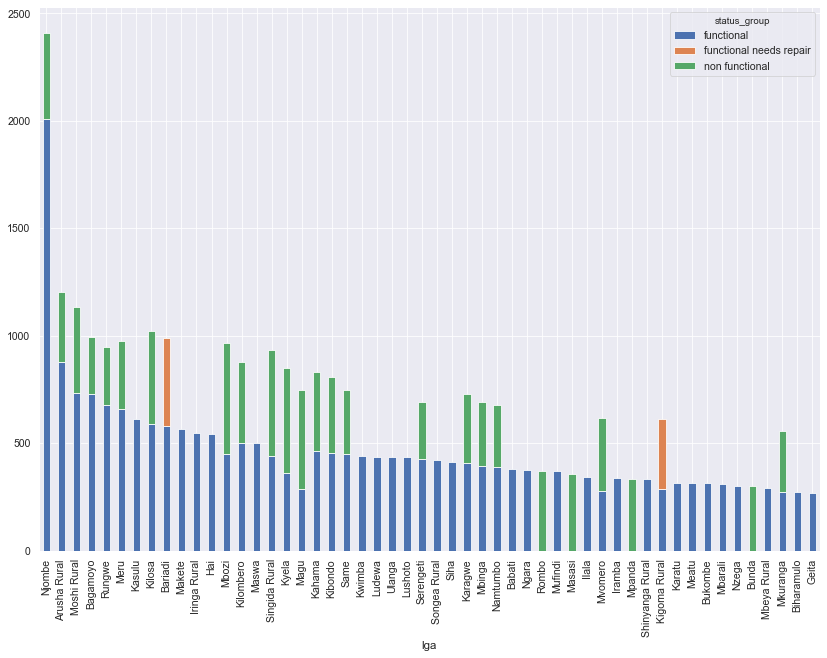

In [84]:
#Top 10 LGA   -check coefficients after

df.groupby('lga')['status_group'].value_counts().sort_values(ascending = False).head(75).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [3]:
#top wards by status group

df.groupby('ward')['status_group'].value_counts().sort_values(ascending = False).head(100).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

NameError: name 'df' is not defined

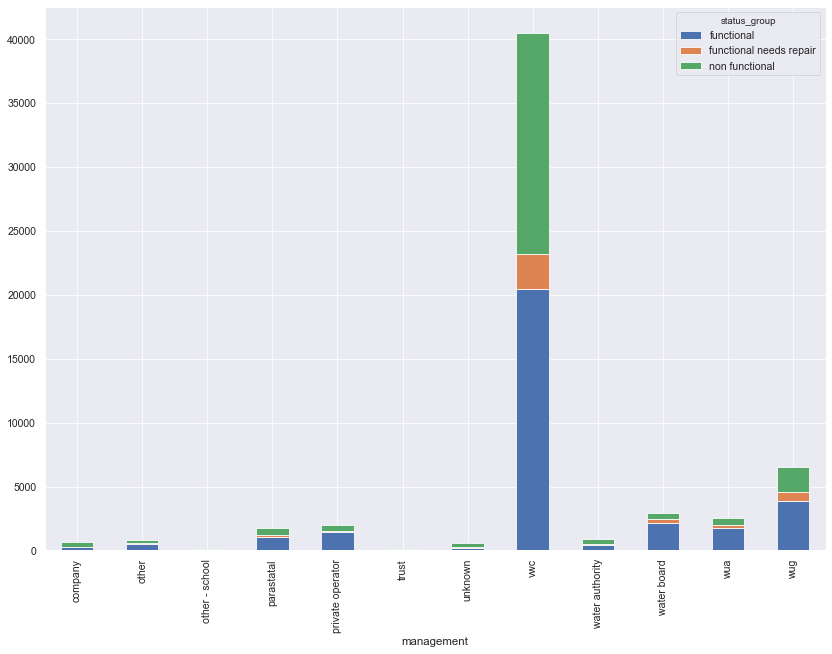

In [91]:
#group by management, keeping only VWC

df.groupby('management')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

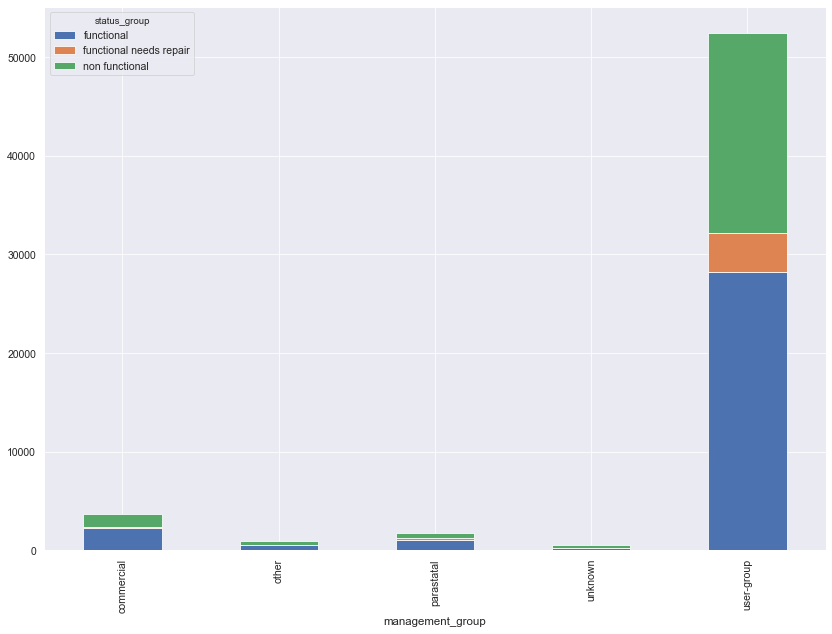

In [94]:
#grouped by management group keeping only user-group

df.groupby('management_group')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

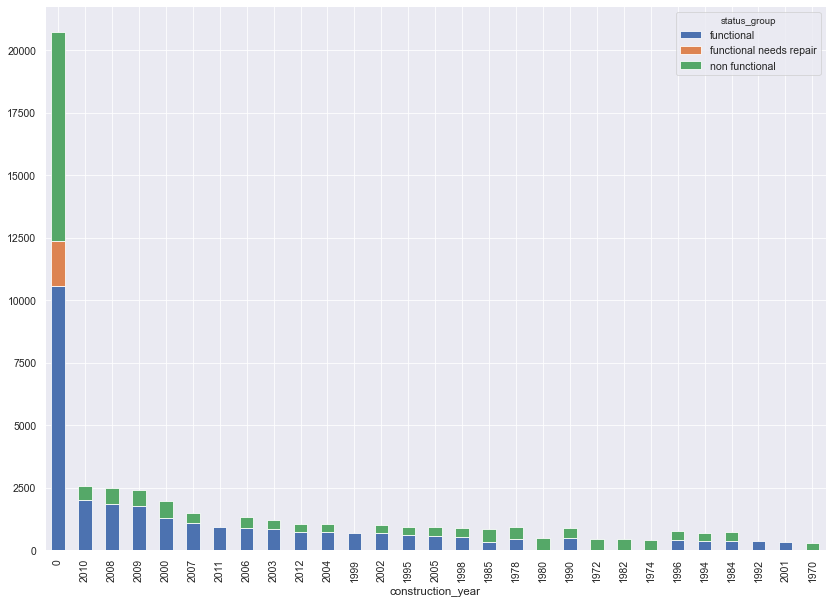

In [95]:
#construction data

df.groupby('construction_year')['status_group'].value_counts().sort_values(ascending = False).head(50).unstack().plot(kind = 'bar', stacked = True, figsize=(14,10))

In [ ]:
# 0 = 0 , less than 1990 = 1 , greater than 1990 = 2

status_group
functional                 AxesSubplot(0.125,0.125;0.775x0.755)
functional needs repair    AxesSubplot(0.125,0.125;0.775x0.755)
non functional             AxesSubplot(0.125,0.125;0.775x0.755)
Name: construction_year, dtype: object

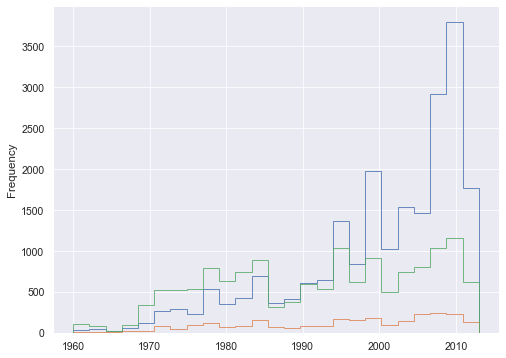

In [105]:
#separated by 1990 for the cut off for nonfunctional vs functional


df[df['construction_year'] > 1 ].groupby('status_group')['construction_year'].plot(kind='hist', histtype='step', bins= 25, figsize=(8,6))

### Makeshift Pipeline for data (transforming cats to dummies + concating conts + droppping missing vals)

In [125]:

def pipeline_df(df):
    
    installer_dummies = pd.get_dummies(df['installer'], prefix='installer')
    installer_dummies = installer_dummies[['installer_DWE' , 'installer_Government']]

    funder_dummies = pd.get_dummies(df['funder'], prefix='funder')
    funder_dummies = funder_dummies[['funder_Hesawa' , 'funder_Danida', 'funder_Government Of Tanzania']]

    subvillage_dummies = pd.get_dummies(df['subvillage'], prefix='subvillage')
    subvillage_dummies = subvillage_dummies[['subvillage_Madukani' , 'subvillage_Shuleni', 'subvillage_Majengo']]

    district_dummies = pd.get_dummies(df['district_code'], prefix='district')
    district_dummies = district_dummies[['district_1' , 'district_2', 'district_3', 'district_4']]

    df['construction_year'] = [0 if x == 0 else 1 if x <= 1990 else 2 for x in df['construction_year']]
    year_dummies = pd.get_dummies(df['construction_year'], prefix='construction_year', drop_first=True)

    lga_dummies = pd.get_dummies(df['lga'], prefix='lga')

    lga_dummies = lga_dummies[['lga_Njombe',          
                                'lga_Arusha Rural',
                                'lga_Moshi Rural',   
                                'lga_Bariadi',         
                                'lga_Rungwe',         
                                'lga_Kilosa',         
                                'lga_Kasulu',          
                                'lga_Mbozi',           
                                'lga_Meru',            
                                'lga_Bagamoyo' ]]

    basin_dummies = pd.get_dummies(df['basin'], prefix = 'basin_', drop_first = True)

    region_dummies = pd.get_dummies(df['region'], prefix = 'region_', drop_first = True)

    extraction_dummies = pd.get_dummies(df['extraction_type_class'], prefix = 'extraction_', 
                                        drop_first = True)

    payment_dummies = pd.get_dummies(df['payment'], prefix = 'payment_', drop_first = True)

    quality_dummies = pd.get_dummies(df['quality_group'], prefix = 'quality_', drop_first = True)

    quantity_dummies = pd.get_dummies(df['quantity'], prefix = 'quantity_', drop_first = True)

    source_type_dummies = pd.get_dummies(df['source_type'], prefix = 'source_type', 
                                         drop_first = True)

    source_class_dummies = pd.get_dummies(df['source_class'], prefix = 'source_class', 
                                          drop_first = True)

    waterpoint_type_dummies = pd.get_dummies(df['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                           drop_first = True)

    permit_dict = {True: 1,
                   False: 0}

    df[['permit', 'public_meeting']] = df[['permit', 'public_meeting']].replace(permit_dict)

    df = pd.concat([df, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                         basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                         quality_dummies, quantity_dummies, funder_dummies, installer_dummies, 
                         subvillage_dummies, district_dummies,lga_dummies, year_dummies], axis = 1)

    df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                       'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                       'quantity_group', 'source', 'waterpoint_type', 'funder', 'longitude', 
                       'latitude', 'num_private', 'installer', 'subvillage', 'district_code', 
                       'lga', 'scheme_management', 'extraction_type_group', 'construction_year', 
                       'basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                       'quantity','source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

    df['ward'] = np.where(df['ward'] == 'Mishamo', 1, 0)
    df['management'] = np.where(df['management'] == 'vwc', 1, 0)
    df['management_group'] = np.where(df['management_group'] == 'user-group', 1, 0)
    
    return df

## Train test split with new model 

In [126]:
df = pipeline_df(df)

In [128]:
#split predictors and target

X_new = df.drop('status_group', axis=1)
y_new = df['status_group']

In [129]:
#split for training

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 20, test_size = .25) 

In [130]:
#XGBOOST MODEL with new dummies 

xgb_df = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)


In [131]:
#fit new model to new data + predict

xgb_df.fit(X_train, y_train)

y_pred_xgb = xgb_df.predict(X_test)

In [151]:
with open('xgb_model_with_nan', 'wb') as handle:
    pickle.dump(xgb_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [133]:
xgb_df.feature_importances_

array([0.00693948, 0.00349294, 0.00485886, 0.00332114, 0.00433689,
       0.00497842, 0.0059697 , 0.00519827, 0.0060761 , 0.        ,
       0.00362959, 0.01698866, 0.15283357, 0.00744933, 0.00570617,
       0.00892157, 0.        , 0.01109764, 0.00657779, 0.00380921,
       0.0090993 , 0.01203588, 0.00529837, 0.00653292, 0.00656153,
       0.00906398, 0.00429234, 0.0081346 , 0.00470069, 0.00908195,
       0.01110148, 0.0403937 , 0.00588285, 0.02841408, 0.00863191,
       0.00507465, 0.0058414 , 0.01259432, 0.01460233, 0.00506535,
       0.0088153 , 0.00655821, 0.01182046, 0.00497051, 0.00689545,
       0.00783837, 0.00772188, 0.00771741, 0.00666724, 0.00657996,
       0.00872869, 0.02994437, 0.00450075, 0.00891123, 0.00190812,
       0.00222435, 0.00416866, 0.00514853, 0.00842751, 0.00383546,
       0.00615651, 0.00288618, 0.0027458 , 0.00915626, 0.00306557,
       0.00621029, 0.02171559, 0.02246349, 0.06939911, 0.02195963,
       0.00517973, 0.00382393, 0.00744073, 0.00471217, 0.00641

In [134]:
#accuracy test score

print('Test Accuracy score:', accuracy_score(y_test, y_pred_xgb))

Test Accuracy score: 0.7929292929292929


### Validation Dataset

In [38]:
test_df = pd.read_csv('Test_set_values.csv', index_col=0)

In [39]:
test_df = pipeline_df(test_df)

## First Logistic Regression to Fill in permit and public

In [ ]:
#holdout data

In [8]:
#values for test for permit and public meeting

x_permit_test = df[df['permit'].isnull() == True].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)
x_public_test = df[df['public_meeting'].isnull() == True].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [9]:
#values as new targets

y_permit = df[df['permit'].isnull() == False]['permit']
y_public = df[df['public_meeting'].isnull() == False]['public_meeting']

In [10]:
#balancing the row number for training

In [11]:
#values for training for permit and public

x_permit = df[df['permit'].isnull() == False].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)
x_public = df[df['public_meeting'].isnull() == False].drop(columns = ['permit', 'public_meeting', 'status_group'], axis=1)

In [12]:
#splitting training data for permit

X1_train, X1_test, y1_train, y1_test = train_test_split(x_permit, y_permit, random_state = 20, test_size = .25) 

In [280]:
#params for log reg grid search

log_params = {'penalty': ['l1', 'l2'],
             'tol': [.0001, .001, .01, .1],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'C': [.01, .1, 1],
             'max_iter': [100, 500 ,1000]}

In [19]:
#logistic regression model to use for grid search for permit

permit_log =  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

permit_log.fit(X1_train, y1_train)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
#gridsearch for log reg

grid_search1 = GridSearchCV(permit_log, log_params, cv=3, verbose=1, n_jobs= -1)

#fitting the gridsearch 
grid_search1.fit(X1_train,y1_train)

#predicting test using gridsearch best est
Xgrid_preds = grid_search1.best_estimator_.predict(X1_test)

In [287]:
#checking accuracy score from grid search

accuracy_score(y1_test, Xgrid_preds)

0.7875195229305694

### logistic regression model to use for grid search for public

In [14]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x_public, y_public, random_state = 20, test_size = .25) 

In [15]:
#public target using the same log reg model + fitting + predicting

public_log =  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

public_log.fit(X2_train, y2_train)

public_train_preds = public_log.predict(X2_train)
public_test_preds = public_log.predict(X2_test)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [16]:
#checking accuracy score for public

print(accuracy_score(y2_train, public_train_preds))
print(accuracy_score(y2_test, public_test_preds))

0.799709862303503
0.7998858528929157


### predicting NaN values for public + permit

In [17]:
#creating df for public_meeting (predicted) to replace NaN values of the original data

public_values = public_log.predict(x_public_test)
pub_df = pd.DataFrame(public_values)
x_public_test.reset_index(inplace=True)
pub_df = pd.concat([x_public_test, pub_df], axis=1)
pub_df.rename(columns={0: 'public_meeting'}, inplace=True)

In [20]:
#creating df for public_meeting (predicted) to replace NaN values of the original data

permit_values = permit_log.predict(x_permit_test)
perm_df = pd.DataFrame(permit_values)
x_permit_test.reset_index(inplace=True)
perm_df = pd.concat([x_permit_test, perm_df], axis=1)
perm_df.rename(columns={0:'permit'}, inplace=True)

In [21]:
#set id's for the predicted values for perm and pub

perm_df = perm_df.set_index('id')['permit']
pub_df = pub_df.set_index('id')['public_meeting']

In [22]:
#fillna using the above predicted values merging on id's

df['permit'].fillna(perm_df, inplace = True)
df['public_meeting'].fillna(pub_df, inplace = True)

### XGB model with imputed values

In [383]:
xgb4_df = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

X4 = df.drop('status_group', axis=1)
y4 = df['status_group']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state = 20, test_size = .25) 

xgb_df.fit(X4_train, y4_train)

y_pred_xgb4 = xgb_df.predict(X4_test)



Test Accuracy score:  0.7953535353535354


In [ ]:
#testing accuracy score of new xgb model

print('Test Accuracy score: ', accuracy_score(y_test, y_pred_xgb4))

### Applying logistic regression for NaN values on validation data

In [40]:
test_public_test = test_df[test_df['public_meeting'].isnull() == True].drop(columns = ['permit', 'public_meeting'], axis=1)
test_permit_test = test_df[test_df['permit'].isnull() == True].drop(columns = ['permit', 'public_meeting'], axis=1)

In [41]:
test_public_values = public_log.predict(test_public_test)
test_permit_values = permit_log.predict(test_permit_test)

In [42]:
test_public_df = pd.DataFrame(test_public_values)
test_permit_df = pd.DataFrame(test_permit_values)

In [43]:
test_public_test.reset_index(inplace=True)
test_public_df = pd.concat([test_public_test, test_public_df], axis=1)
test_public_df.rename(columns={0:'public_meeting'}, inplace=True)

test_permit_test.reset_index(inplace=True)
test_perm_df = pd.concat([test_permit_test, test_permit_df], axis=1)
test_perm_df.rename(columns={0:'permit'}, inplace=True)

In [44]:
test_perm_df = test_perm_df.set_index('id')['permit']
test_public_df = test_public_df.set_index('id')['public_meeting']

In [45]:
test_df['permit'].fillna(test_perm_df, inplace = True)
test_df['public_meeting'].fillna(test_public_df, inplace = True)

In [400]:
#predicting validation data and saving it into a csv

test_results3 = xgb4_df.predict(test_df)
testing_results3 = pd.DataFrame(test_results3, columns = ['status_group'])
test_labels3 = pd.concat([id_df, testing_results3], axis = 1)
test_labels3 = test_labels3.set_index('id')
test_labels3.to_csv('testing_results_ver3.csv')

### XGB MODEL USING TOMEK LINKS

In [25]:
from collections import Counter
from imblearn.under_sampling import TomekLinks

In [27]:
X4 = df.drop('status_group', axis=1)
y4 = df['status_group']

In [28]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state = 20, test_size = .25) 

In [29]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X4_train, y4_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'functional': 21278, 'non functional': 14643, 'functional needs repair': 3309})


In [30]:
#xgbmodel using tomek

xgb_tl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)


In [31]:
#fitting + predicting

xgb_tl.fit(X_res, y_res)

y_pred_xgbtl = xgb_tl.predict(X4_test)

In [32]:
#testing accuracy score of latest xgb model

print('Test Accuracy score: ', accuracy_score(y4_test, y_pred_xgbtl))

Test Accuracy score:  0.7894276094276095


In [48]:
#tomek links test submission

test_results4 = xgb_tl.predict(test_df)
testing_results4 = pd.DataFrame(test_results4, columns = ['status_group'])
test_labels4 = pd.concat([id_df, testing_results4], axis = 1)
test_labels4 = test_labels4.set_index('id')
test_labels4.to_csv('testing_results_ver5.csv')

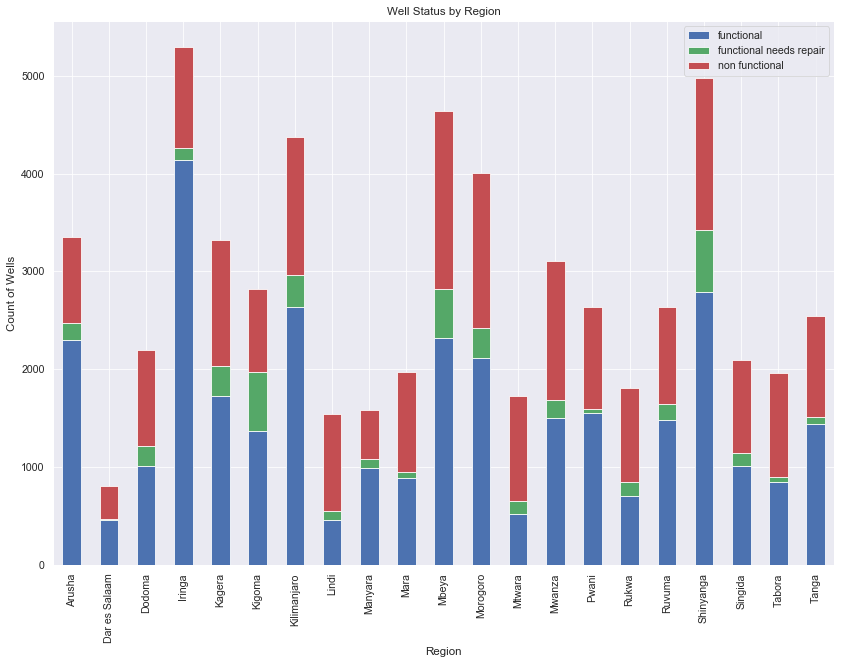

In [89]:
df.groupby('region')['status_group'].value_counts().sort_values(ascending = False).unstack().plot(kind = 'bar', color = ('b', 'g', 'r'), stacked = True, figsize=(14,10))

plt.title('Well Status by Region')
plt.ylabel('Count of Wells')
plt.xlabel('Region')
plt.legend(loc = 1)
        

In [21]:
df = pipeline_df(df)

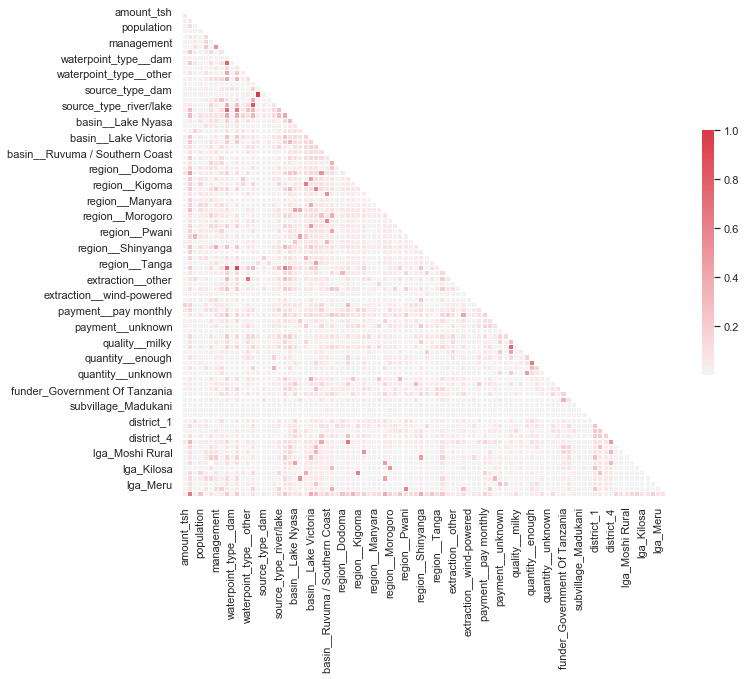

In [23]:
sns.set(style="white")


# Compute the correlation matrix
corr = np.abs(df.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [27]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [35]:
df_cons = df[df['construction_year'] > 100]
df_cons = df_cons[df_cons['population'] < 9900]

In [53]:
df_cons.rename(columns = {'construction_year': 'Construction Year', 'population': 'Population'}, inplace = True)

Text(0.5, 1.0, 'Construction Year v Population by Status Group')

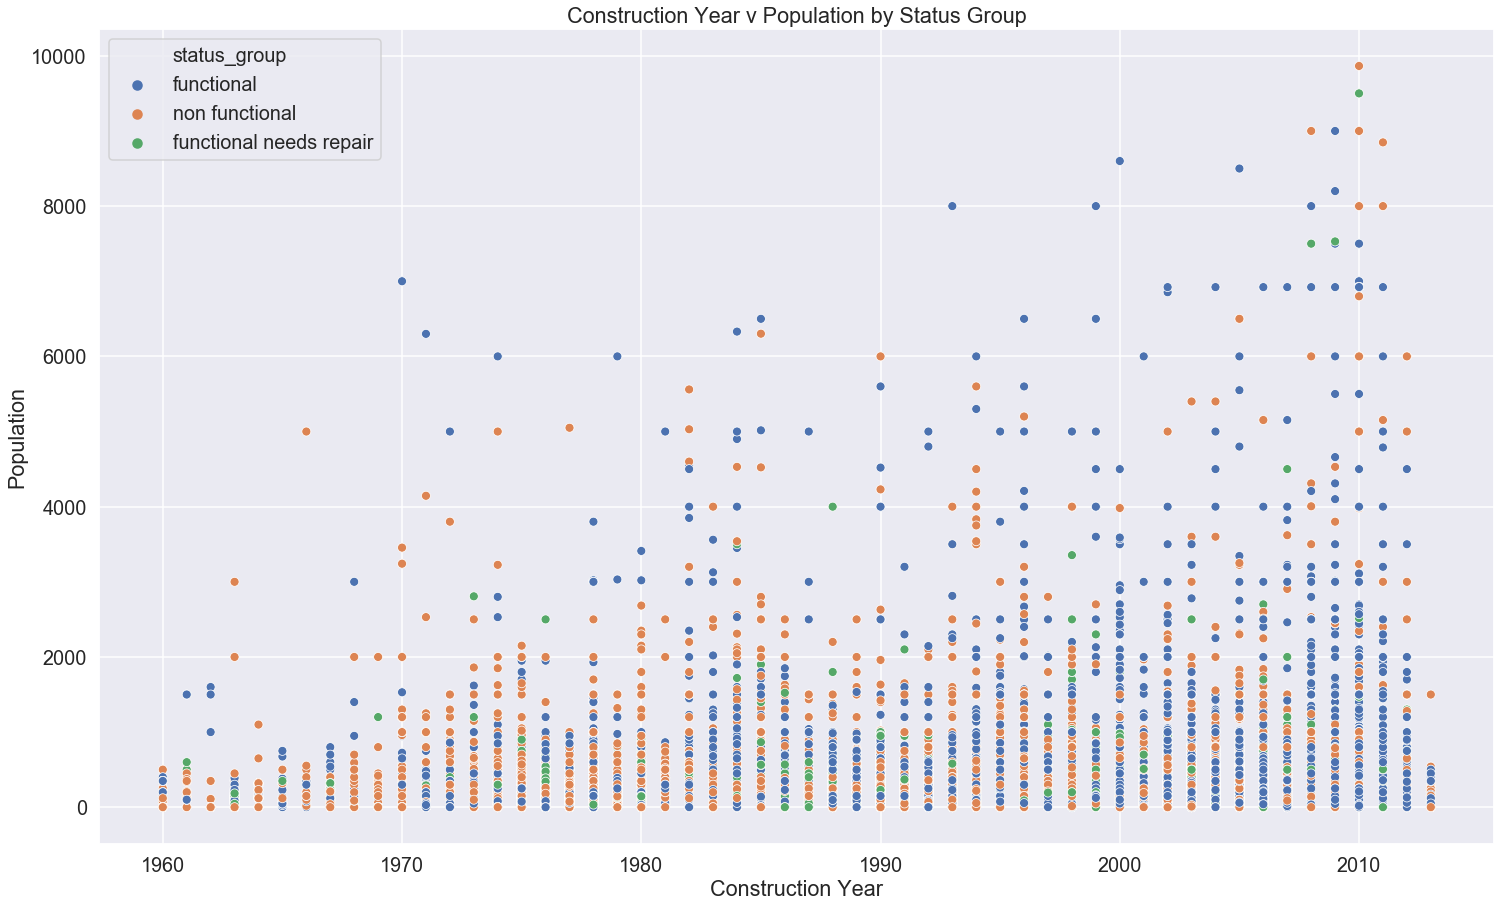

In [105]:
sns.set(context='talk', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

fig3, ax3 = plt.subplots(figsize=(25,15))
sns.scatterplot(x='Construction Year', y="Population",
                hue="status_group", data=df_cons,
                ax = ax3).set_title('Construction Year v Population by Status Group')


Text(0.5, 0, 'Count of Wells')

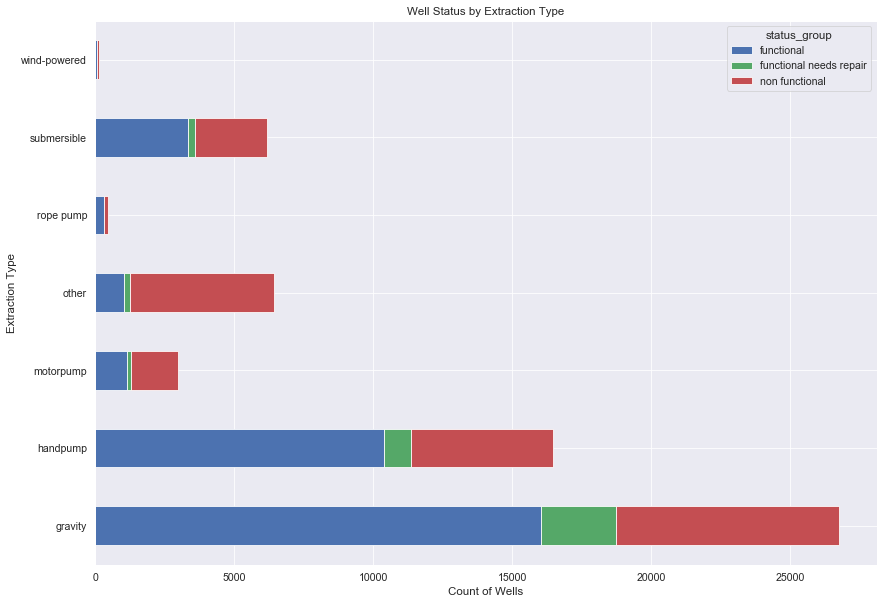

In [91]:
df.groupby('extraction_type_class')['status_group'].value_counts().sort_values(ascending = False).unstack().plot(kind = 'barh', color = ('b', 'g', 'r'), stacked = True, figsize=(14,10))

plt.title('Well Status by Extraction Type')
plt.ylabel('Extraction Type')
plt.xlabel('Count of Wells')

In [119]:
df[df['region'] == 'Mtwara']['quantity'].value_counts()

enough          764
dry             539
insufficient    252
seasonal        164
unknown          11
Name: quantity, dtype: int64

In [121]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [137]:
len(xgb_df.feature_importances_)

94

In [140]:
len(X_new.columns)

94

In [142]:
feature_importances = {}

In [143]:
for i in range(len(xgb_df.feature_importances_)):
    feature_importances[X_new.columns[i]] = xgb_df.feature_importances_[i]

In [145]:
import operator
sorted_ft = sorted(feature_importances.items(), key=operator.itemgetter(1))

In [148]:
sorted_ft[-10:]

[('waterpoint_type__improved spring', 0.01698866),
 ('quantity__enough', 0.021715593),
 ('quantity__unknown', 0.021959627),
 ('quantity__insufficient', 0.02246349),
 ('region__Kigoma', 0.028414082),
 ('extraction__other', 0.02994437),
 ('region__Iringa', 0.040393703),
 ('lga_Bariadi', 0.051438916),
 ('quantity__seasonal', 0.06939911),
 ('waterpoint_type__other', 0.15283357)]

Text(0, 0.5, 'Feature')

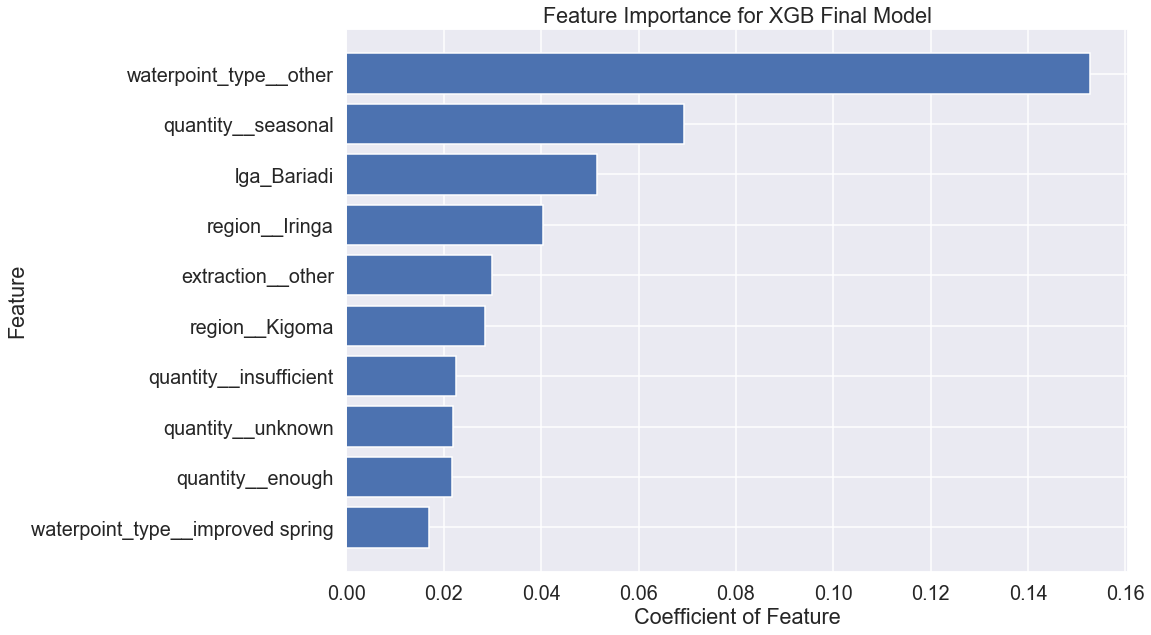

In [150]:
var = []
num = []
for i,j in sorted_ft[-10:]:
    var.append(i)
    num.append(j)
fig, ax = plt.subplots(figsize=(14,10))
plt.barh(var, num)
plt.title('Feature Importance for XGB Final Model')
plt.xlabel('Coefficient of Feature')
plt.ylabel('Feature')